### Generative model, and sampling from it

We start by creating an instance of our prior and likelihood models.

In [1]:
# Given
# -----
# N : integer, number of neurons.
# K : integer, number of trials.
# C : integer, number of stimulus conditions.
# seed : integer, random seed for reproducibility.
# sigma_m : float, prior kernel smoothness.

# Create instances of prior and likelihood distributions and generate some synthetic data.
import sys
import jax
from numpyro import optim

# sys.path.append('wishart-process')
import inference
import models
import visualizations
import evaluation
import utils

import jax.numpy as jnp
import numpyro


import itertools
from tqdm import tqdm
import numpy as np
from scipy.io import loadmat

In [5]:
#import data

import matplotlib.pyplot as plt
HUNGRY_DECONV = np.load('../../Data/predictions_fullTrace_hungry.npy', allow_pickle=True)
print(HUNGRY_DECONV.shape)

FOOD_RESTRICTED_HUNGRY = [1,2,3,6,7,9,11,12]
CONTROL_HUNGRY = [0,4,5,8,10,13]


AngStim_data = '../../Data/metadata_deconv/stimAngle_hungry.mat'
ANG_STIM_DATA = loadmat(AngStim_data, simplify_cells= True)
HUNGRY_ANGLE = ANG_STIM_DATA['order_of_stim_arossAnimals']
print(HUNGRY_ANGLE[0].shape)

SfStim_data = '../../Data/metadata_deconv/stimSpatFreq_hungry.mat'
SF_STIM_DATA = loadmat(SfStim_data, simplify_cells= True)
HUNGRY_SF = SF_STIM_DATA['stimSpatFreq_arossAnimals']
print(HUNGRY_SF[0].shape)

def resort_preprocessing(datum,angle_arr,sf_arr,animal):
    data = np.copy(datum[animal,:])
    neurons = data[0].shape[0]
    reshape_data = np.full((60,neurons,data[0].shape[1]), np.nan)
    for i in range(60):
        reshape_data[i,:,:] = data[i]

    reshape_data = reshape_data.reshape(60,neurons,12,120)
    reshape_data = np.transpose(reshape_data,(1,2,0,3))
    #Remove first two neurons
    reshape_data = reshape_data[2:,:,:,:]

    #Remove None trials
    max_trial = np.argmax(np.isnan(reshape_data[0,1,:,0]))
    reshape_data = reshape_data[:,:,:max_trial,:]

    # Remove beginning and last bit # HMMMM should I do this?
    # reshape_data[:,0,:,:32] = np.nan
    # reshape_data[:,-1,:,88:] = np.nan
    # print(np.any(np.isnan(reshape_data)))
    # print(reshape_data.shape)
    
    # Reorder angles
    angles = np.copy(angle_arr[animal])
    for itrials in range(angles.shape[1]):
        order = angles[:,itrials]-1
        reshape_data[:,:,itrials,:] = reshape_data[:,order,itrials,:]

    # Reorder SFs
    reshaped_data = []
    sfs = np.copy(sf_arr[animal])
    for experiment in range(1,6):
        mask = sfs == experiment
        reshaped_data.append(reshape_data[:,:,mask,:])

    max_trials = max([exp.shape[2] for exp in reshaped_data])
    # Pad the data for experiments with fewer trials
    for i in range(len(reshaped_data)):
        if reshaped_data[i].shape[2] < max_trials:
            padding = max_trials - reshaped_data[i].shape[2]
            reshaped_data[i] = np.pad(reshaped_data[i], ((0, 0),(0, 0),(0, padding),(0, 0)), mode='constant', constant_values=np.nan)

    reshaped_data = np.stack(reshaped_data,axis=2)    

    return reshaped_data
x = resort_preprocessing(HUNGRY_DECONV,HUNGRY_ANGLE,HUNGRY_SF,0)
print(np.sum(np.isnan(x)))




def remove_neurons(datum, angles,sfs, animal, count = False):
    neurons_to_keep = []
    data = resort_preprocessing(datum,angles,sfs,animal)
    number_neurons = data.shape[0]    
    for i in range(number_neurons):
        # print(np.nanmean(data[i, :, :, :, 40:80], axis = 3))
        stim_average = np.mean(data[i, :, :, :, 40:80], axis = 3) # OKAY TO NOT HAVE NANMEAN?
        best_sf = np.argmax(np.nanmean(stim_average, axis = (0,2))).astype('int')
        best_angle = np.argmax(np.nanmean(stim_average[:,best_sf,:], axis = 1)).astype('int')
        averaged_calcium = np.nanmean(stim_average[best_angle,best_sf,:])
        
        grey_data = data[i, :, :, :, 0:20]
        # grey_data = np.concatenate((data[i, :, :, :, 0:40], data[i, :, :, :, 80:]), axis = 3)
        grey_average = np.mean(grey_data, axis = 3)
        best_sf = np.argmax(np.nanmean(grey_average, axis = (0,2))).astype(int)
        best_angle = np.argmax(np.nanmean(grey_average[:,best_sf,:], axis = 1)).astype(int)
        average_grey = np.nanmean(grey_average[best_angle,best_sf,:])
        std_grey = np.nanstd(grey_average[best_angle,best_sf,:])
        
        if np.abs(averaged_calcium - average_grey) >= 1.69*std_grey:
            neurons_to_keep.append(i)
    
    # Keep only the neurons that meet the condition
    data_filtered = data[neurons_to_keep, :, :,:,:]
    if count:
        return data_filtered.shape[0]/data.shape[0]

    return data_filtered



(14, 60)
(12, 55)
(55,)
450560


In [ ]:
remove_mean = np.zeros((14,120))
normal_mean = np.zeros((14,120))
for i in range(14):
    remove_mean[i,:] = np.nanmean(resort_preprocessing(HUNGRY_DECONV,HUNGRY_ANGLE,HUNGRY_SF,i)[:,4,:,:,:],axis = (0,1,2))
    normal_mean[i,:] = np.nanmean(remove_neurons(HUNGRY_DECONV,HUNGRY_ANGLE,HUNGRY_SF,i)[:,4,:,:,:],axis = (0,1,2))
plt.plot(np.mean(remove_mean,axis=0), label = 'Remove Neurons')
plt.plot(np.mean(normal_mean,axis=0), label = 'Normal Neurons')
plt.xlabel('Timebin')
plt.ylabel('Firing Rate')
plt.title('Average Firing Rate of all traces')
plt.legend()
plt.grid()

In [6]:
TEST_DATA = resort_preprocessing(HUNGRY_DECONV,HUNGRY_ANGLE,HUNGRY_SF,0)[:,:,1,:,40:80]
# Animal = 0, SF = 0 and during response
TEST_RESPONSE = jnp.nanmean(TEST_DATA,axis = -1) # Shape N x C x K 
TEST_RESPONSE = jnp.transpose(TEST_RESPONSE, (2,1,0)) # Shape K X C X N
print(TEST_RESPONSE.shape)

N = TEST_RESPONSE.shape[2]
C = TEST_RESPONSE.shape[1]
K = TEST_RESPONSE.shape[0]
SEED = 1
PERIOD = C
X_CONDITIONS = jnp.linspace(0,C-1,C)

(11, 12, 128)


In [7]:
hyperparams = {
    'sigma_m': 0.5,
    'gamma_gp': 1e-5,
    'beta_gp': 10.0,
    'sigma_c': 0.5,
    'gamma_wp': 1e-6,
    'beta_wp': 1.0,
    'p': N+1
    }

In [8]:
# Initialise Kernel and Model
periodic_kernel_gp = lambda x, y: hyperparams['gamma_gp']*(x==y) + hyperparams['beta_gp']*jnp.exp(-jnp.sin(jnp.pi*jnp.abs(x-y)/PERIOD)**2/(2*hyperparams['sigma_m']**2))
periodic_kernel_wp = lambda x, y: hyperparams['gamma_wp']*(x==y) + hyperparams['beta_wp']*jnp.exp(-jnp.sin(jnp.pi*jnp.abs(x-y)/PERIOD)**2/(2*hyperparams['sigma_c']**2))

# Prior distribution (GP and WP)
gp = models.GaussianProcess(kernel=periodic_kernel_gp,N=N)
wp = models.WishartProcess(kernel =periodic_kernel_wp,P=hyperparams['p'],V=1e-2*jnp.eye(N), optimize_L=False)
likelihood = models.NormalConditionalLikelihood(N)


Now we are ready to fit the model to data and infer posterior distributions over neural means and covariances. Then we can sample from the inferred posterior and compute their likelihoods.

In [9]:
# Given
# -----
# x : ndarray, (num_conditions x num_variables), stimulus conditions.
# y : ndarray, (num_trials x num_conditions x num_neurons), neural firing rates across C conditions repeated for K trials.

# Infer a posterior over neural means and covariances per condition.

# Joint distribution
joint = models.JointGaussianWishartProcess(gp,wp,likelihood) 

# Mean field variational family
inference_seed = 2
varfam = inference.VariationalNormal(joint.model)
adam = optim.Adam(1e-1)
key = jax.random.PRNGKey(inference_seed)

varfam.infer(adam,X_CONDITIONS,TEST_RESPONSE,n_iter = 10000,key=key)
joint.update_params(varfam.posterior)

E0509 17:28:33.303119    9778 buffer_comparator.cc:156] Difference at 192: 0, expected 29.5135
E0509 17:28:33.303166    9778 buffer_comparator.cc:156] Difference at 193: 0, expected 33.1421
E0509 17:28:33.303172    9778 buffer_comparator.cc:156] Difference at 194: 0, expected 37.7762
E0509 17:28:33.303175    9778 buffer_comparator.cc:156] Difference at 195: 0, expected 33.5764
E0509 17:28:33.303178    9778 buffer_comparator.cc:156] Difference at 196: 0, expected 30.7878
E0509 17:28:33.303181    9778 buffer_comparator.cc:156] Difference at 197: 0, expected 30.9412
E0509 17:28:33.303184    9778 buffer_comparator.cc:156] Difference at 198: 0, expected 30.266
E0509 17:28:33.303187    9778 buffer_comparator.cc:156] Difference at 199: 0, expected 33.7627
E0509 17:28:33.303190    9778 buffer_comparator.cc:156] Difference at 200: 0, expected 36.2597
E0509 17:28:33.303193    9778 buffer_comparator.cc:156] Difference at 201: 0, expected 35.1717
2025-05-09 17:28:33.303207: E external/xla/xla/serv

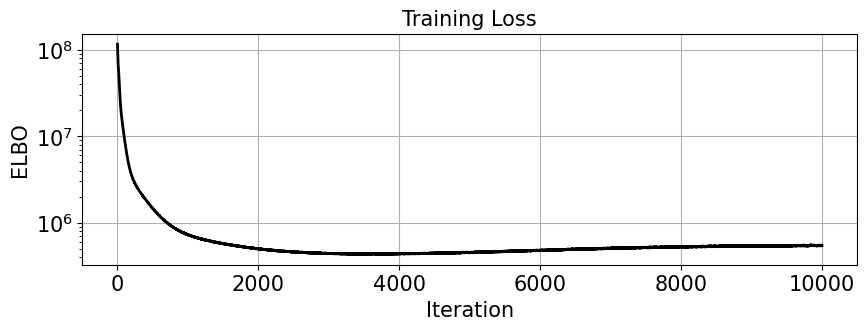

In [10]:
# %% Visualization
visualizations.plot_loss(
    [varfam.losses],xlabel='Iteration',ylabel='ELBO',titlestr='Training Loss',colors=['k'],
)

We can sample from the inferred posterior, compute likelihoods and summary statistics, evaluate its mode, compute derivatives, and more.

/home/castedo/Documents/Files/Data Analysis/wishart-process/wishart-process/visualizations.py:63: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


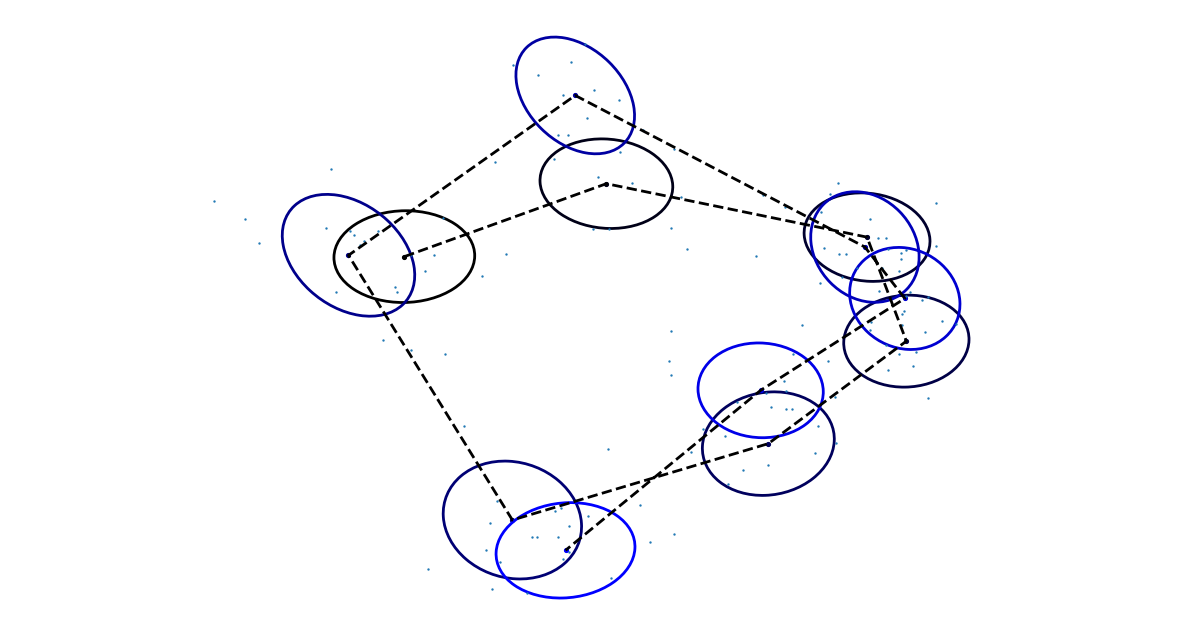

In [11]:
# Posterior distribution
posterior = models.NormalGaussianWishartPosterior(joint,varfam,X_CONDITIONS)

# Sample from the posterior
with numpyro.handlers.seed(rng_seed=inference_seed):
    mu_hat, sigma_hat, F_hat = posterior.sample(X_CONDITIONS)

visualizations.visualize_pc(
    mu_hat[:,None],sigma_hat,pc=TEST_RESPONSE.reshape(TEST_RESPONSE.shape[0]*TEST_RESPONSE.shape[1],-1)
)


# Hyper Param Tuning

In [4]:
def evaluate_hyperparameters(hyperparams, x_train, y_train, x_test, y_test, n_iter=5000):

    # Initialize kernels with the hyperparameters
    periodic_kernel_gp = lambda x, y: hyperparams['gamma_gp']*(x==y) + hyperparams['beta_gp']*jnp.exp(-jnp.sin(jnp.pi*jnp.abs(x-y)/PERIOD)**2/(2*hyperparams['sigma_m']**2))
    periodic_kernel_wp = lambda x, y: hyperparams['gamma_wp']*(x==y) + hyperparams['beta_wp']*jnp.exp(-jnp.sin(jnp.pi*jnp.abs(x-y)/PERIOD)**2/(2*hyperparams['sigma_c']**2))
    
    # Set up the model
    gp = models.GaussianProcess(kernel=periodic_kernel_gp, N=N)
    wp = models.WishartProcess(kernel=periodic_kernel_wp, P=hyperparams['p'], V=1e-2*jnp.eye(N), optimize_L=False)
    likelihood = models.NormalConditionalLikelihood(N)
    joint = models.JointGaussianWishartProcess(gp, wp, likelihood)
    
    # Set up variational inference
    inference_seed = 2
    key = jax.random.PRNGKey(inference_seed)
    varfam = inference.VariationalNormal(joint.model)
    adam = optim.Adam(1e-1)
    
    # Train the model
    varfam.infer(adam, x_train, y_train, n_iter=n_iter, key=key)
    joint.update_params(varfam.posterior)
    
    posterior = models.NormalGaussianWishartPosterior(joint,varfam,x_train)
    with numpyro.handlers.seed(rng_seed=inference_seed):
        mu_hat, sigma_hat, F_hat = posterior.sample(x_train)
    mu_empirical = y_train.mean(0)
    log_likelihood = likelihood.log_prob(y_test['x'], mu_empirical, sigma_hat).flatten()

    # # Create posterior and compute log likelihood on validation data
    # posterior = models.NormalGaussianWishartPosterior(joint, varfam, x_train)
    # Compute log likelihood (directly using the posterior's log_prob method)
    # This uses x_val and y_val_data
    # log_likelihood = posterior.log_prob(x_test, y_test['x'])

    return log_likelihood.mean()

def optimize_hyperparameters(x_train, y_train, x_val, y_val, hyperparam_grid, n_iter=5000):
    
    # Generate all combinations of hyperparameters
    keys = list(hyperparam_grid.keys())
    values = list(hyperparam_grid.values())
    hyperparameter_combinations = [dict(zip(keys, combo)) for combo in itertools.product(*values)]
    
        
    best_score = float('-inf')  # For log-likelihood, higher is better
    best_hyperparams = None
    
    for i, hyperparams in enumerate(tqdm(hyperparameter_combinations)):
        try:
            print(f"\nEvaluating hyperparameters {i+1}/{len(hyperparameter_combinations)}:")
            score = evaluate_hyperparameters(hyperparams, x_train, y_train, x_val, y_val, n_iter)
            
            print(f"Score: {score}")
            
            # Update best if needed
            if score > best_score:
                best_score = score
                best_hyperparams = hyperparams
                print(f"New best score: {best_score}")
                
        except Exception as e:
            print(f"Error with hyperparams {hyperparams}: {str(e)}")
            continue
    
    return best_hyperparams, best_score

# Main execution
if __name__ == "__main__":
    # Split data
    data = utils.split_data(x=X_CONDITIONS[:, None], y=TEST_RESPONSE, 
                           train_trial_prop=0.8, train_condition_prop=0.8, seed=SEED)
    x_train, y_train, _, _, x_test, y_test, _, _, _, _, _, _, _, _ = data
    
    print('x conditions train ', x_train.shape)     # x_train 80% of conditions: 9/12

    print('y data train ', y_train.shape)     # ytrain 80% conditions and trials : 9/12, 8/11

    print('x conditions val ', x_test.shape)     # x_test 20% of conditions: 3/12

    print('y_val, (x) ', y_test['x'].shape)     # y_test['x'] 20% of trials and 80% conditions: 9/12, 3/11

    print('y_val, (x_test) ', y_test['x_test'].shape)     # y_test['x_test'] 100% of trials and 20% conditions: 3/12, 11/11
    x_train = x_train.reshape(x_train.shape[0])
    x_test = x_test.reshape(x_test.shape[0])

    # Define a more focused hyperparameter grid
    hyperparam_grid = {
        'sigma_m': [0.1,0.2,0.3,0.4, 0.5,0.6,0.7, 1.0,5],
        'gamma_gp': [1e-6,1e-5,1e-4,1e-3],
        'beta_gp': [1e-1,1,1e1,1e2],
        'sigma_c': [0.1,0.2,0.3,0.4, 0.5,0.6,0.7, 1.0,5],
        'gamma_wp': [1e-6,1e-5,1e-4,1e-3],
        'beta_wp': [1e-1,1,1e1,1e2],
        'p': [N+1]
    }
    hyperparam_grid = {
    'sigma_m': [0.5,1,2],
    'gamma_gp': [1e-6],
    'beta_gp': [1e-1],
    'sigma_c': [0.5,1],
    'gamma_wp': [1e-6],
    'beta_wp': [1e-1,1],
    'p': [N+1]
    }
    
    # Run optimization with a time budget of 12 hours
    best_hyperparams, best_score = optimize_hyperparameters(
        x_train, y_train, x_test, y_test, 
        hyperparam_grid, 
        n_iter=400)
    
    print("\n=== Optimization Results ===")
    print(f"Best hyperparameters:")
    for k, v in best_hyperparams.items():
        print(f"  {k}: {v}")
    print(f"Best score: {best_score}")

x conditions train  (9, 1)
y data train  (8, 9, 128)
x conditions val  (3, 1)
y_val, (x)  (3, 9, 128)
y_val, (x_test)  (11, 3, 128)


  0%|          | 0/12 [00:00<?, ?it/s]


Evaluating hyperparameters 1/12:


E0509 13:28:40.430981   73987 buffer_comparator.cc:156] Difference at 144: 0, expected 28.1238
E0509 13:28:40.431036   73987 buffer_comparator.cc:156] Difference at 145: 0, expected 33.6028
E0509 13:28:40.431046   73987 buffer_comparator.cc:156] Difference at 146: 0, expected 27.5554
E0509 13:28:40.431052   73987 buffer_comparator.cc:156] Difference at 147: 0, expected 30.9252
E0509 13:28:40.431058   73987 buffer_comparator.cc:156] Difference at 148: 0, expected 32.9702
E0509 13:28:40.431063   73987 buffer_comparator.cc:156] Difference at 149: 0, expected 33.2255
E0509 13:28:40.431069   73987 buffer_comparator.cc:156] Difference at 150: 0, expected 33.9838
E0509 13:28:40.431075   73987 buffer_comparator.cc:156] Difference at 151: 0, expected 34.0488
E0509 13:28:40.431081   73987 buffer_comparator.cc:156] Difference at 152: 0, expected 26.5899
E0509 13:28:40.431087   73987 buffer_comparator.cc:156] Difference at 153: 0, expected 31.0815
2025-05-09 13:28:40.431105: E external/xla/xla/ser

Score: -44.86600875854492
New best score: -44.86600875854492

Evaluating hyperparameters 2/12:


 17%|█▋        | 2/12 [00:22<01:38,  9.83s/it]

Score: 15.059883117675781
New best score: 15.059883117675781

Evaluating hyperparameters 3/12:


 25%|██▌       | 3/12 [00:25<01:01,  6.81s/it]

Score: -237.25408935546875

Evaluating hyperparameters 4/12:


 33%|███▎      | 4/12 [00:28<00:42,  5.37s/it]

Score: -57.79541778564453

Evaluating hyperparameters 5/12:


 42%|████▏     | 5/12 [00:31<00:31,  4.57s/it]

Score: -107.95608520507812

Evaluating hyperparameters 6/12:


 50%|█████     | 6/12 [00:35<00:24,  4.10s/it]

Score: -22.56005859375

Evaluating hyperparameters 7/12:


 58%|█████▊    | 7/12 [00:38<00:19,  3.81s/it]

Score: -315.1044921875

Evaluating hyperparameters 8/12:


 67%|██████▋   | 8/12 [00:41<00:14,  3.61s/it]

Score: -109.8790283203125

Evaluating hyperparameters 9/12:


 75%|███████▌  | 9/12 [00:44<00:10,  3.49s/it]

Score: -105.46057891845703

Evaluating hyperparameters 10/12:


 83%|████████▎ | 10/12 [00:48<00:06,  3.42s/it]

Score: -20.819318771362305

Evaluating hyperparameters 11/12:


 92%|█████████▏| 11/12 [00:51<00:03,  3.34s/it]

Score: -371.5875549316406

Evaluating hyperparameters 12/12:


100%|██████████| 12/12 [00:54<00:00,  4.54s/it]

Score: -128.1168212890625

=== Optimization Results ===
Best hyperparameters:
  sigma_m: 0.5
  gamma_gp: 1e-06
  beta_gp: 0.1
  sigma_c: 0.5
  gamma_wp: 1e-06
  beta_wp: 1
  p: 129
Best score: 15.059883117675781


In [ ]:
Optimize L or not
WP lrd?


# Compare to Empirical

In [ ]:
#Also Compute empirical mean and covariance

import pandas as pd
empirical_mu = jnp.nanmean(TEST_RESPONSE,axis=0)
print(empirical_mu.shape)
# empirical_cov =jnp.cov(TEST_RESPONSE,axis=0)
empirical_sigma = jnp.zeros((C, N, N))
for i in range(C):
    dat = TEST_RESPONSE[:,i,:] # Shape K x N
    df = pd.DataFrame(dat)
    covariances = df.cov().to_numpy()
    empirical_sigma.at[i].set(covariances)
print(empirical_sigma.shape)

visualizations.visualize_pc(
    empirical_mu[:,None],empirical_sigma,pc=TEST_RESPONSE.reshape(TEST_RESPONSE.shape[0]*TEST_RESPONSE.shape[1],-1)
)
visualizations.draw_ellipse(empirical_mu[:,None],empirical_sigma,plt.cm.hsv(np.linspace(0,1,len(None)+1)[0:-1])[:,0:3], ax = plt.gca())



# Test Unseen conditions 

/home/castedo/Documents/Files/Data Analysis/wishart-process/wishart-process/visualizations.py:63: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


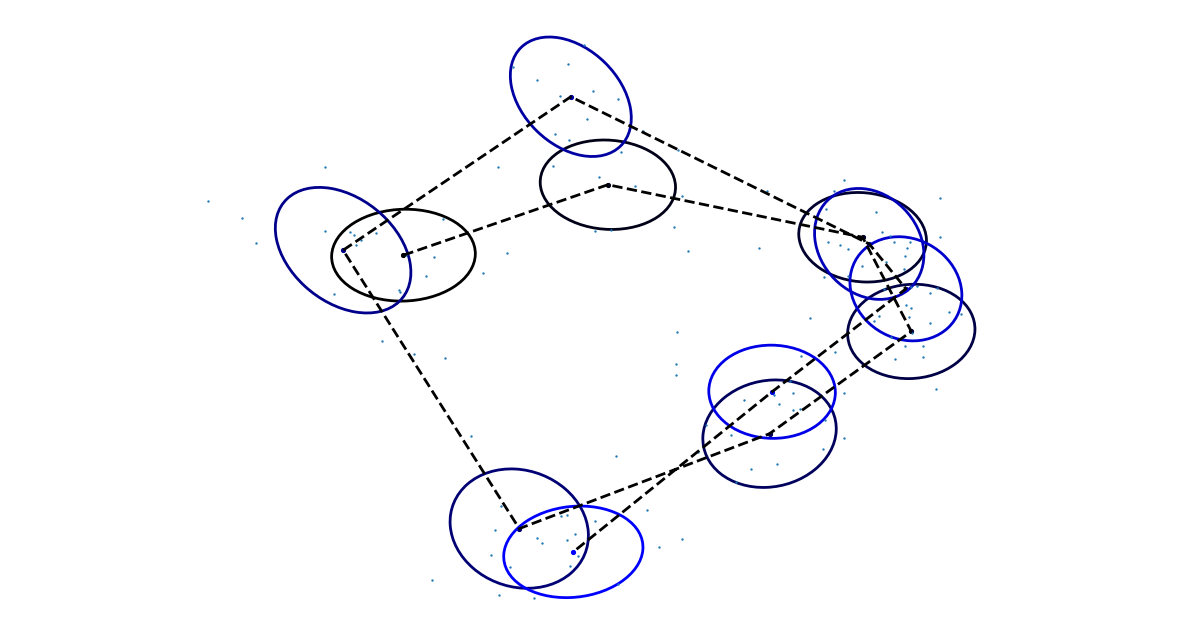

In [14]:
# Given
# -----
# X_test : ndarray, (num_test_conditions x num_variables), test data from first network.

# Interpolate covariances in unseen test conditions 
# test at 200 points instead of C
x_test = jnp.linspace(0, C-1, 12)  # shape (200, 1)

with numpyro.handlers.seed(rng_seed=SEED):
    mu_test_hat, sigma_test_hat, F_test_hat = posterior.sample(x_test)

visualizations.visualize_pc(
    mu_test_hat[:,None],sigma_test_hat,pc=TEST_RESPONSE.reshape(TEST_RESPONSE.shape[0]*TEST_RESPONSE.shape[1],-1)
)


# Next things

In [16]:
# Evaluate posterior mode
with numpyro.handlers.seed(rng_seed=SEED):
    mu_hat, sigma_hat, F_hat = posterior.mode(x)

# Evaluate the function derivative of the posterior mode 
with numpyro.handlers.seed(rng_seed=SEED):
    mu_prime, sigma_prime = posterior.derivative(x)

# For the Poisson model, compute summary statistics (such as mean firing rate)
with numpyro.handlers.seed(rng_seed=SEED):
    mu_hat = posterior.mean_stat(lambda x: x, x)

2025-05-09 17:40:57.169569: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3021] Can't reduce memory use below -218.96MiB (-229596368 bytes) by rematerialization; only reduced to 4.83GiB (5190451200 bytes), down from 4.83GiB (5190451200 bytes) originally
2025-05-09 17:41:07.219219: W external/xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.83GiB (rounded to 5190451200)requested by op 
2025-05-09 17:41:07.219637: W external/xla/xla/tsl/framework/bfc_allocator.cc:512] *_________******************************____________________________________________________________
E0509 17:41:07.219690    9778 pjrt_stream_executor_client.cc:3026] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 5190451200 bytes. [tf-allocator-allocation-error='']


XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 5190451200 bytes.

In [ ]:
# %%
def fisher_information(x,mu_prime,sigma,sigma_prime=None):
    '''Computing Fisher Information with and without access to the gradient 
    of the covariances wrt the input parameter x
    '''
    tr = lambda x: jnp.diag(x).sum()
    sigma_inv = [np.linalg.inv(sigma[i]) for i in range(len(x))]
    
    fi = [mu_prime[:,[i]].T@sigma_inv[i]@mu_prime[:,[i]] for i in range(len(x))]
    if sigma_prime is not None:
        fi = [fi[i] + .5*tr((sigma_inv[i]@sigma_prime[i])**2) for i in range(len(x))]
    
    return np.array(fi)
# Evaluate the function derivative of the posterior mode 
with numpyro.handlers.seed(rng_seed=SEED):
    mu_hat, sigma_hat, F_hat = posterior.sample(X_CONDITIONS)
    mu_prime, sigma_prime = posterior.derivative(X_CONDITIONS)
    # Compute Fisher Information
    fi = fisher_information(X_CONDITIONS,mu_prime,sigma_hat,sigma_prime)
    print(fi.shape)
    print(fi)

E0509 17:45:44.832123    9778 pjrt_stream_executor_client.cc:3026] Execution of replica 0 failed: INTERNAL: jaxlib/gpu/solver_handle_pool.cc:37: operation gpusolverDnCreate(&handle) failed: cuSolver internal error


XlaRuntimeError: INTERNAL: jaxlib/gpu/solver_handle_pool.cc:37: operation gpusolverDnCreate(&handle) failed: cuSolver internal error

: 

In [15]:
def fisher_information_mode(posterior, x, constant_cov: bool = False):
    """
    Compute Fisher Information at each row of x, using the posterior mode and its derivative.

    Args:
      posterior     : fitted posterior with .mode(x) → (mu, sigma, _)
                      and .derivative(x) → (mu_prime, sigma_prime)
      x             : [M, D] array of test inputs
      constant_cov  : if True, drop the covariance‐gradient term

    Returns:
      fi            : [M] array of FI(x) at each test input
    """
    # 1) get posterior mode and its derivative
    mu_hat,   sigma_hat, _   = posterior.mode(x)        # mu_hat: [M, L], sigma_hat: [M, L, L]
    mu_prime, sigma_prime    = posterior.derivative(x)  # mu_prime: [M, L], sigma_prime: [M, L, L]

    # 2) invert each Sigma(x)
    inv_sigma = jnp.linalg.inv(sigma_hat)               # [M, L, L]

    # 3) define FI for a single input
    def fi_per_point(mu_p, sig_p, inv_sig, mu_h):
        # term1 = μ'ᵀ Σ^{-1} μ'
        t1 = mu_p @ (inv_sig @ mu_p)

        if constant_cov:
            return t1

        # term2 = ½ tr[(Σ^{-1} Σ')²]
        A  = inv_sig @ sig_p
        t2 = 0.5 * jnp.trace(A @ A)
        return t1 + t2

    # 4) vectorize over the M test points
    fi = jax.vmap(fi_per_point, in_axes=(0, 0, 0, 0))(
        mu_prime, sigma_prime, inv_sigma, mu_hat
    )  # → [M]

    return fi


# x_test is your [M x D] grid of new conditions
fi_vals = fisher_information_mode(posterior, x_test, constant_cov=False)
print("Fisher Information at test points:", fi_vals)

AssertionError: 